In [5]:
import numpy as np
import pandas as pd
from pandas import DataFrame
from pandas import Series
import matplotlib
import matplotlib.pyplot as plt
import time 
import operator
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [6]:
#压缩数据内存#
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)


    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df
def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df

In [9]:
#加载数据#
train = import_data('C:/input/train_data.csv')
target = import_data('C:/input/train_target.csv')
test = import_data('C:/input/test_data.csv')
print(train.shape)
print(target.shape)
print(test.shape)

Memory usage of dataframe is 1796.90 MB
Memory usage after optimization is: 488.64 MB
Decreased by 72.8%
Memory usage of dataframe is 1.42 MB
Memory usage after optimization is: 0.41 MB
Decreased by 70.8%
Memory usage of dataframe is 526.70 MB
Memory usage after optimization is: 143.23 MB
Decreased by 72.8%
(61866, 3807)
(61866, 3)
(18134, 3807)


In [10]:
for feature in train.columns:
    print(feature + '===== '+ str(train[feature].dtype))
pass

idx===== int32
X0===== float16
X1===== float16
X2===== float16
X3===== float16
X4===== float16
X5===== float16
X6===== float16
X7===== float16
X8===== float16
X9===== float16
X10===== float16
X11===== float16
X12===== float16
X13===== float16
X14===== float16
X15===== float16
X16===== float16
X17===== float16
X18===== float16
X19===== float16
X20===== float16
X21===== float16
X22===== float16
X23===== float16
X24===== float16
X25===== float16
X26===== float16
X27===== float16
X28===== float16
X29===== float16
X30===== float16
X31===== float16
X32===== float16
X33===== float16
X34===== float16
X35===== float16
X36===== float16
X37===== float16
X38===== float16
X39===== float16
X40===== float16
X41===== float16
X42===== float16
X43===== float16
X44===== float16
X45===== float16
X46===== float16
X47===== float16
X48===== float16
X49===== float16
X50===== float16
X51===== float16
X52===== float16
X53===== float16
X54===== float16
X55===== float16
X56===== float16
X57===== float16
X58===== 

In [11]:
features = [feat for feat in train.columns.values if feat not in ['idx']]
print("所有特征的维度：",len(features))

所有特征的维度： 3806


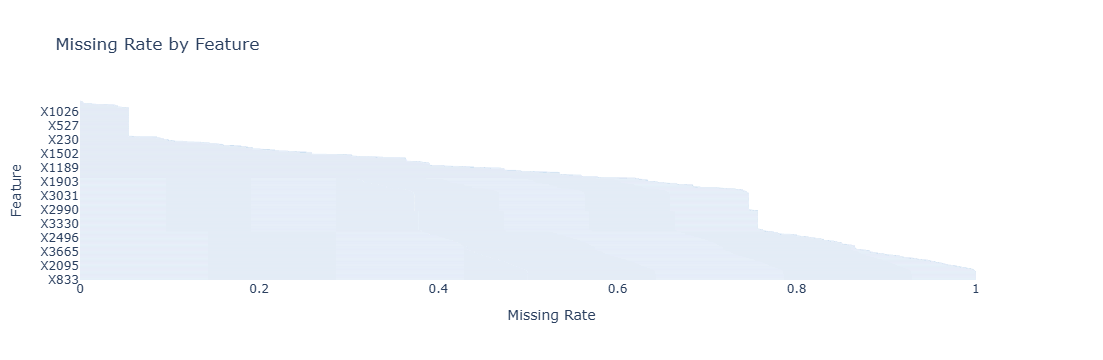

In [17]:
import plotly.express as px

# 计算每个特征的缺失值个数
missing_values_count = train.isnull().sum()

# 计算每个特征的缺失率
missing_values_rate = missing_values_count / len(train)

# 将缺失率按降序排列
missing_values_rate = missing_values_rate.sort_values(ascending=False)

# 创建一个DataFrame来存储缺失率数据，以便使用Plotly
missing_rate_df = missing_values_rate.reset_index()
missing_rate_df.columns = ['Feature', 'Missing Rate']

# 绘制缺失率统计图，并设置条形颜色为深蓝色
fig = px.bar(missing_rate_df, x='Missing Rate', y='Feature', title='Missing Rate by Feature',
             orientation='h', text='Feature', labels={'Missing Rate': 'Missing Rate', 'Feature': 'Feature'},
             color_discrete_sequence=['#1f77b4'])  # 设置深蓝色

# 设置图表的背景颜色为白色
fig.update_layout(plot_bgcolor='white', paper_bgcolor='white')

# 显示图表
fig.show()

# 导出图表为HTML文件
fig.write_html('missing_rate_plot.html')

In [19]:
def ceate_feature_map(features):
    outfile = open('lgb.fmap', 'w',encoding='utf8')
    i = 0
    for feat in features:
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
        i = i + 1
    print("map over!")
    outfile.close()

# 特征map文件
ceate_feature_map(features)

map over!


In [4]:
!pip install lightgbm

In [21]:
# -----------------LGB tree模型------------------------
# 开始训练

# 采取分层采样
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from lightgbm import early_stopping, log_evaluation
import operator
import time

# 定义回调函数
callbacks = [
    log_evaluation(period=100),  # 每100轮评估一次
    early_stopping(stopping_rounds=100, first_metric_only=True)  # 如果100轮内没有提升则停止
]

print("start：********************************")
start = time.time()

print('......................Start train all data .......................')

# 最后用全部数据train
train_all = lgb.Dataset(train[features], target['y'])
# 设置参数
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'auc'},
    'max_depth': 4,
    'min_child_weight': 6,
    'num_leaves': 16,
    'learning_rate': 0.02,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.7,
    'bagging_freq': 5,
    #'lambda_l1':0.25,
    #'lambda_l2':0.5,
    #'scale_pos_weight':1,
}
model = lgb.train(params,
                train_all,
                num_boost_round=450,
                valid_sets=[train_all],
                callbacks=callbacks)

end = time.time()
print("......................run with time: ",(end - start) / 60.0 )
print("over:*********************************")

start：********************************
......................Start train all data .......................
[LightGBM] [Info] Number of positive: 11340, number of negative: 50526
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.004657 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 324928
[LightGBM] [Info] Number of data points in the train set: 61866, number of used features: 3666
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.183299 -> initscore=-1.494152
[LightGBM] [Info] Start training from score -1.494152
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

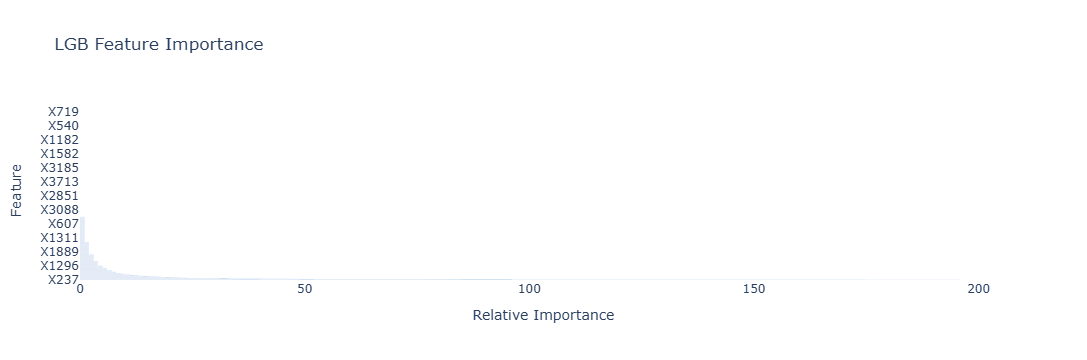

In [35]:
# 计算特征重要性并创建DataFrame
df = pd.DataFrame({'feature': features, 'importance': model.feature_importance()}).sort_values(by='importance', ascending=False)

# 使用Plotly创建交互式条形图
fig = px.bar(df,  # 展示所有特征
             x='importance', 
             y='feature', 
             orientation='h', 
             title='LGB Feature Importance',
             labels={'importance': 'Relative Importance', 'feature': 'Feature'},
             color_discrete_sequence=['#1f77b4'])  # 设置条形图为深蓝色

# 设置图表的背景颜色为白色
fig.update_layout(plot_bgcolor='white', paper_bgcolor='white')
# 显示图表
fig.show()
# 导出图表为HTML文件
fig.write_html('lgb_feature_importance.html')

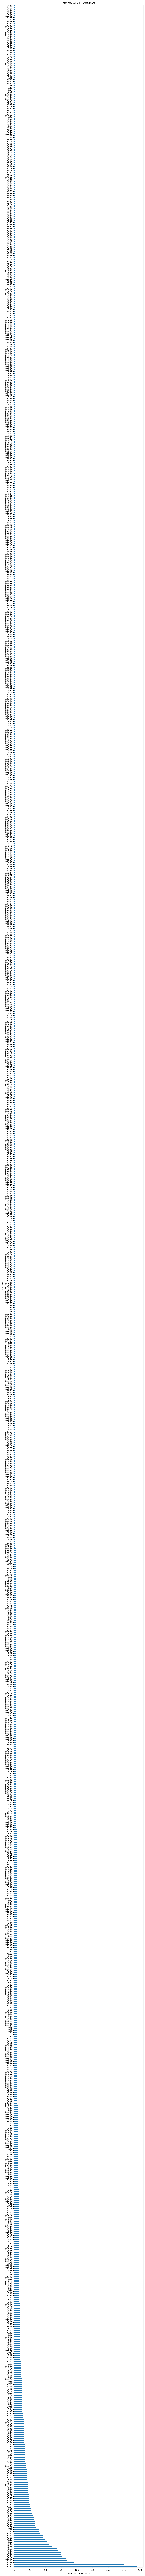

In [21]:
df = pd.DataFrame({'feature': features,'importance': model.feature_importance()}).sort_values(by='importance',ascending = False) # 降序
df.loc[df['importance']!=0,:].plot(kind = 'barh', x='feature', y='importance', legend=False, figsize=(10,200))
plt.title('lgb Feature Importance')
plt.xlabel('relative importance')
plt.show()

In [23]:
# 不等于 0 的特征 
use = df.loc[df['importance']!=0,:]
most_feat = use.iloc[:30,0].values.tolist()
print(most_feat)

['X237', 'X280', 'X163', 'X177', 'X2009', 'X277', 'X244', 'X49', 'X248', 'X68', 'X276', 'X279', 'X45', 'X70', 'X249', 'X263', 'X195', 'X255', 'X67', 'X93', 'X16', 'X121', 'X118', 'X258', 'X40', 'X141', 'X24', 'X106', 'X117', 'X146']


In [25]:
import os

# 检查 'data' 目录是否存在，如果不存在则创建它
data_dir = 'data'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [27]:
# 很多特征重要性为0
df = pd.DataFrame({'feature': features,'importance': model.feature_importance()}).sort_values(by='importance',ascending = True)
df.to_csv('data/feature_imp.csv',index = False)                                    # 3806
df.loc[df['importance']==0,:].to_csv('data/feature_0_imp.csv',index = False)       # 2481   
df.loc[df['importance']!=0,:].to_csv('data/feature_1_imp.csv',index = False)       # 1325

In [29]:
print("特征重要性为0的特征：",df.loc[df['importance']==0,:].shape[0])
df.loc[df['importance']==0,:]

特征重要性为0的特征： 2481


,feature,importance
3805,X3805,0
2991,X2991,0
2990,X2990,0
2989,X2989,0
1709,X1709,0
...,...,...
834,X834,0
3329,X3329,0
3328,X3328,0
857,X857,0


In [37]:
train_id = target.pop('idx')
y = target["y"].values
X = train[features].values
print("X shape:",X.shape)
print("y shape:",y.shape)

test_id = test.pop('idx')
test = test[features].values
print("test shape",test.shape)

X shape: (61866, 3806)
y shape: (61866,)
test shape (18134, 3806)


In [49]:
# 随机抽取一部分的训练、验证，看看特征重要性
from sklearn.model_selection import StratifiedShuffleSplit
N = 1
skf = StratifiedShuffleSplit(n_splits=N, test_size=0.2, random_state=2023)
for k,(train_in,test_in) in enumerate(skf.split(X,y)):
    X_train,X_test,y_train,y_test = X[train_in],X[test_in],\
                                    y[train_in],y[test_in]
    print("train shape",X_train.shape)
    print("valid shape",X_test.shape)
    # 数据结构
    lgb_train = lgb.Dataset(X_train, y_train, feature_name = features)
    lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

    # 设置参数
    params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': {'auc'},
        'max_depth': 4,
        'min_child_weight': 6,
        'num_leaves': 16,
        'learning_rate': 0.02,
        'feature_fraction': 0.7,
        'bagging_fraction': 0.7,
        'bagging_freq': 5,
        #'lambda_l1':0.25,
        #'lambda_l2':0.5,
        #'scale_pos_weight':1,
    }
    callbacks = [
    lgb.early_stopping(stopping_rounds=100, verbose=True),  # 早停回调
    lgb.log_evaluation(period=100)  # 每100轮打印一次训练信息
    ]

    print('................Start training..........................')
    # train
   
    gbm = lgb.train(params,
                    lgb_train,
                    num_boost_round=2000,
                    valid_sets=lgb_eval,
                    callbacks=callbacks)

    print('................Start predict .........................')
    # 预测
    y_pred = gbm.predict(X_test,num_iteration=gbm.best_iteration)
    # 评估
    tmp_auc = roc_auc_score(y_test,y_pred)
    print("valid auc:",tmp_auc)
    

train shape (49492, 3806)
valid shape (12374, 3806)
................Start training..........................
[LightGBM] [Info] Number of positive: 9072, number of negative: 40420
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.516678 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 322235
[LightGBM] [Info] Number of data points in the train set: 49492, number of used features: 3649
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.183302 -> initscore=-1.494132
[LightGBM] [Info] Start training from score -1.494132
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

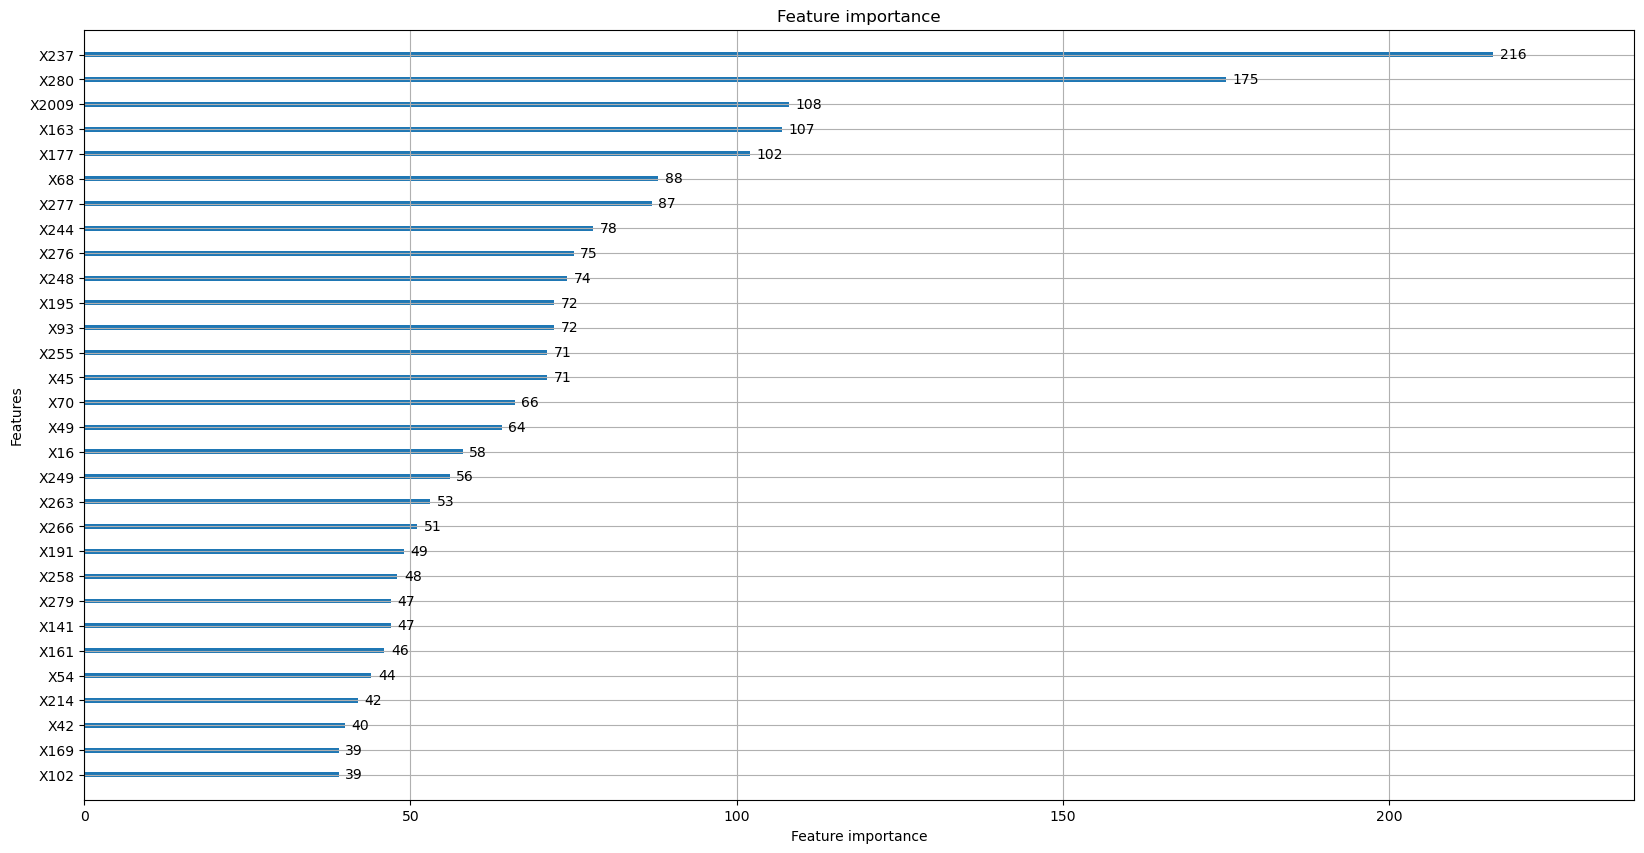

In [51]:
lgb.plot_importance(gbm,max_num_features = 30,figsize=(20,10))
plt.show()

In [53]:
df1 = pd.DataFrame({'feature': features,'importance': gbm.feature_importance()}).sort_values(by='importance',ascending = True)
df1.to_csv('data/feature_imp1.csv',index = False)                                    
df1.loc[df1['importance']==0,:].to_csv('data/feature_0_imp1.csv',index = False)      
df1.loc[df1['importance']!=0,:].to_csv('data/feature_1_imp1.csv',index = False)     

aa = df.loc[df['importance']==0,'feature'].values.tolist()
print(len(aa))
bb = df1.loc[df1['importance']==0,'feature'].values.tolist()
print(len(bb))
for i in bb:
    if i not in aa:
        print(i)

2481
1955
X3141
X1706
X1701
X1684
X3148
X1690
X1761
X1764
X1767
X1756
X1600
X1601
X1613
X1594
X1592
X3162
X1674
X1651
X1779
X1781
X1782
X3084
X1923
X3026
X3035
X1826
X1830
X1843
X1832
X3122
X1808
X1852
X1889
X3096
X1897
X3093
X1887
X1885
X1867
X1906
X3297
X1303
X1304
X1306
X1309
X1271
X1348
X1354
X1321
X1323
X1330
X1369
X1186
X1503
X1488
X1490
X1493
X1553
X1550
X3243
X1483
X1405
X1421
X1422
X1387
X1427
X1461
X3264
X1450
X1448
X2639
X2451
X2453
X2459
X2899
X2762
X2761
X2772
X2770
X2757
X2684
X2681
X2671
X2669
X2699
X2722
X2733
X2446
X2173
X2140
X2118
X2122
X2132
X2134
X2175
X2178
X2225
X2185
X2954
X2198
X2202
X2951
X2207
X2208
X2031
X2048
X2051
X2052
X2022
X2979
X2099
X2364
X2380
X2381
X2383
X2344
X2346
X2350
X2348
X2416
X2424
X2442
X2411
X2272
X2278
X2283
X2265
X2937
X2253
X2287
X2289
X2315
X2311
X2298
X2303
X3495
X541
X539
X530
X528
X519
X515
X596
X590
X3481
X3484
X3485
X448
X437
X428
X497
X496
X491
X486
X474
X722
X3447
X642
X669
X3428
X702
X3431
X3433
X3434
X3439
X3631
X3640
X3641
X3

In [55]:
for i in aa:
    if i not in bb:
        print(i)

X1709
X1710
X1713
X1714
X1716
X1717
X2993
X1691
X1692
X1696
X1699
X1722
X1745
X1751
X1744
X1752
X1754
X1760
X1742
X1682
X3046
X3045
X3048
X3039
X1633
X1641
X1631
X1642
X1603
X1605
X1609
X1620
X3058
X1612
X3054
X1645
X1667
X1668
X1670
X1671
X1672
X1664
X3027
X1656
X1658
X1659
X2934
X1871
X2929
X1880
X1881
X2936
X1865
X1864
X1849
X1851
X1853
X1860
X1856
X1912
X1907
X1918
X2901
X1920
X1921
X1924
X1925
X1917
X1847
X2908
X1904
X1888
X1890
X1899
X1846
X1845
X1785
X1786
X1788
X1789
X1784
X1797
X1799
X1800
X1801
X1768
X1771
X1772
X1778
X1804
X2955
X2953
X1833
X1834
X1837
X1839
X1841
X1842
X1803
X1805
X1809
X1820
X1813
X1378
X1379
X1389
X1391
X1392
X1360
X1363
X1366
X1371
X1372
X1394
X1395
X1417
X1419
X1420
X1416
X1428
X1426
X1397
X1404
X1408
X1409
X1412
X1353
X1298
X1299
X1300
X1302
X3198
X3195
X1312
X1293
X1287
X1315
X1338
X1339
X3184
X1341
X1343
X1347
X1349
X1351
X1352
X1314
X1322
X1328
X1435
X1437
X1544
X1545
X1555
X3091
X3120
X1538
X1530
X3108
X3114
X3090
X3070
X1582
X3062
X1595
X1596
X159

In [57]:
print(len(aa))
print(aa)

2481
['X3805', 'X2991', 'X2990', 'X2989', 'X1709', 'X1710', 'X1711', 'X1712', 'X1713', 'X1714', 'X2988', 'X1716', 'X1717', 'X2987', 'X1719', 'X2986', 'X2992', 'X1704', 'X2993', 'X1702', 'X1686', 'X3001', 'X1688', 'X3000', 'X2999', 'X1691', 'X1692', 'X2985', 'X2998', 'X2996', 'X1696', 'X1697', 'X2995', 'X1699', 'X1700', 'X2994', 'X2997', 'X1722', 'X1723', 'X1724', 'X1745', 'X1746', 'X1747', 'X1748', 'X1749', 'X1750', 'X1751', 'X1744', 'X1752', 'X1754', 'X1755', 'X2983', 'X1757', 'X1758', 'X1759', 'X1760', 'X1753', 'X3002', 'X1743', 'X1741', 'X1725', 'X2984', 'X1727', 'X1728', 'X1729', 'X1730', 'X1731', 'X1742', 'X1732', 'X1734', 'X1735', 'X1736', 'X1737', 'X1738', 'X1739', 'X1740', 'X1733', 'X3003', 'X3004', 'X1682', 'X3047', 'X3046', 'X3045', 'X3044', 'X3043', 'X3042', 'X3041', 'X3048', 'X3040', 'X3039', 'X1633', 'X3038', 'X3034', 'X3032', 'X3031', 'X1641', 'X1631', 'X1642', 'X3049', 'X3050', 'X1603', 'X1604', 'X1605', 'X1606', 'X1607', 'X3059', 'X1609', 'X1620', 'X3058', 'X1612', 'X30

In [59]:
print(len(bb))
print(bb)

1955
['X3805', 'X3143', 'X1711', 'X1712', 'X3142', 'X1719', 'X3141', 'X1706', 'X1723', 'X1725', 'X1727', 'X1728', 'X1729', 'X1730', 'X1731', 'X1724', 'X1732', 'X1704', 'X1701', 'X3152', 'X3151', 'X1684', 'X3150', 'X1686', 'X1688', 'X1702', 'X3149', 'X3148', 'X3147', 'X3146', 'X3145', 'X1697', 'X1700', 'X1690', 'X1678', 'X1733', 'X1735', 'X1758', 'X1759', 'X1761', 'X1762', 'X1763', 'X1764', 'X1757', 'X1765', 'X1767', 'X3136', 'X1770', 'X3135', 'X1775', 'X1776', 'X3137', 'X1734', 'X1756', 'X1753', 'X1736', 'X1737', 'X1738', 'X1739', 'X1740', 'X1741', 'X1755', 'X1743', 'X3138', 'X1746', 'X1747', 'X1748', 'X1749', 'X1750', 'X3139', 'X1677', 'X3153', 'X3154', 'X1600', 'X1601', 'X1602', 'X1604', 'X3199', 'X1606', 'X1599', 'X1607', 'X3196', 'X1613', 'X3194', 'X3192', 'X3191', 'X3190', 'X3197', 'X3189', 'X1598', 'X1593', 'X3210', 'X3209', 'X3208', 'X3207', 'X3206', 'X3205', 'X1594', 'X3204', 'X3202', 'X3201', 'X3200', 'X1589', 'X1591', 'X1592', 'X3203', 'X3188', 'X3187', 'X3186', 'X3165', 'X31

In [61]:
useless = list(set(aa) & set(bb)) # 交集
print(len(useless))
print(useless)

1743
['X3250', 'X940', 'X1359', 'X730', 'X3591', 'X779', 'X3313', 'X2575', 'X3116', 'X3318', 'X3514', 'X2811', 'X3253', 'X2560', 'X1168', 'X868', 'X1702', 'X2826', 'X2935', 'X3008', 'X3388', 'X1934', 'X512', 'X3674', 'X2473', 'X2783', 'X2389', 'X1458', 'X2493', 'X3081', 'X3703', 'X3124', 'X2123', 'X1181', 'X320', 'X635', 'X3418', 'X1401', 'X1467', 'X1001', 'X2249', 'X291', 'X3622', 'X3160', 'X2767', 'X2867', 'X665', 'X1240', 'X2910', 'X1041', 'X2641', 'X2933', 'X3107', 'X3200', 'X3232', 'X919', 'X774', 'X309', 'X640', 'X3510', 'X2679', 'X2471', 'X3227', 'X372', 'X2832', 'X1400', 'X410', 'X3392', 'X2996', 'X1180', 'X1192', 'X2849', 'X2126', 'X2638', 'X1272', 'X531', 'X1332', 'X1282', 'X1383', 'X358', 'X910', 'X1731', 'X946', 'X1909', 'X2129', 'X2222', 'X775', 'X3065', 'X957', 'X2690', 'X333', 'X3731', 'X2966', 'X3079', 'X391', 'X3358', 'X3276', 'X2533', 'X3367', 'X2526', 'X3076', 'X2747', 'X1677', 'X1598', 'X990', 'X3145', 'X2553', 'X1724', 'X1669', 'X2786', 'X2285', 'X2358', 'X2872', '

In [69]:
printtest)

[[0.10321045 0.11553955 0.50927734 ...        nan        nan        nan]
 [0.52392578 0.90332031 0.5546875  ...        nan        nan        nan]
 [0.10321045 0.73974609 0.55566406 ...        nan        nan        nan]
 ...
 [0.99072266 0.11553955 0.15429688 ...        nan        nan        nan]
 [0.32128906 0.41430664        nan ...        nan        nan        nan]
 [0.671875   0.51171875 0.60693359 ... 0.64111328 0.65332031 0.76513672]]


In [75]:
data = pd.concat([train,test],axis = 0)

In [2]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import roc_auc_score

all_feats =[]
for i in range(3806):
    feat = "X" + str(i)
    all_feats.append(feat)
print(len(all_feats))
check = list(set(all_feats)-set(useless)) # 这些都是重要性不等于0的特征
print(len(check))

no_xx = []

# 设置参数
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'auc'},
    'max_depth': 4,
    'min_child_weight': 6,
    'num_leaves': 16,
    'learning_rate': 0.02,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.7,
    'bagging_freq': 5,
    #'lambda_l1':0.25,
    #'lambda_l2':0.5,
    #'scale_pos_weight':1,
}

for i in check:
    print("************************** "+ i +" ***********************************")
    train1 = train.copy()
    test1 = test.copy()
    data1 = data.copy()
    train1 = train1.drop(i, axis = 1)
    test1 = test1.drop(i, axis = 1)
    data1 = data1.drop(i, axis = 1)
    print(data1.shape)
    print(train1.shape)
    print(test1.shape) 
    features = [feat for feat in train1.columns.values]
    print("所有特征的维度：",len(features))
    
    train_id = target.pop('idx')
    y = target['y'].values
    X = train1[features].values
    print("X shape:",X.shape)
    print("y shape:",y.shape)

    test_id = test.pop('idx')
    test_data = test1[features].values
    print("test shape",test_data.shape)
    
    N = 1
    skf = StratifiedShuffleSplit(n_splits=N, test_size=0.2, random_state=2024)
    for k,(train_in,test_in) in enumerate(skf.split(X,y)):
        X_train,X_test,y_train,y_test = X[train_in],X[test_in],\
                                        y[train_in],y[test_in]
        print("train shape",X_train.shape)
        print("valid shape",X_test.shape)
        # 数据结构
        lgb_train = lgb.Dataset(X_train, y_train, feature_name = features)
        lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

        print('................Start training..........................')
        # train
        gbm = lgb.train(params,
                        lgb_train,
                        num_boost_round=2000,
                        valid_sets=lgb_eval,
                        early_stopping_rounds=100,
                        verbose_eval=100)

        print('................Start predict .........................')
        # 预测
        y_pred = gbm.predict(X_test,num_iteration=gbm.best_iteration)
        # 评估
        tmp_auc = roc_auc_score(y_test,y_pred)
        tmp_auc = round(tmp_auc,12)
        print("valid auc:",tmp_auc)
    if tmp_auc == 0.823851264445:  # (0.823851264445)
        no_xx.append(i)
    print("*****************************************************************************")
print("没有用的特征：",len(no_xx))
print(no_xx)

3806


NameError: name 'useless' is not defined